In [3]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from collections import Counter

plt.style.use('ggplot')
sns.set_style('ticks')
pd.set_option('precision', 2)
pd.options.display.max_colwidth = 100

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

In [12]:
drug_info_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
drug_info_df.head()

,Drug Name,Synonyms,Target,Target Pathway,Selleckchem Cat#,CAS number,PubCHEM,Others,entropy,max_conc,...,median_ic50_9f,log2_median_ic50_9f,log2_median_ic50_hn,median_ic50_hn,median_ic50_3f_hn,log2_median_ic50_3f_hn,median_ic50_9f_hn,log2_median_ic50_9f_hn,num_sensitive,num_sensitive_hn
Drug ID,,,,,,,,,,,,,,,,,,,,,
1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole-4-carboxamide",AMPK agonist,Metabolism,S1802,2627-69-2,65110,NaN,6.03,2000.00,...,2.07e+02,7.69,9.94,9.82e+02,3.27e+02,8.35,1.09e+02,6.77,476,27
1003,Camptothecin,"7-Ethyl-10-Hydroxy-Camptothecin, SN-38, Irinotecan, Camptothecin-11, Camptosar",TOP1,DNA replication,S1288,7689-03-4,104842,"(SN-38, S4908, 86639-52-3) (Irinotecan, S1198, 97682-44-5)",4.61,0.10,...,2.00e-03,-8.96,-7.59,5.20e-03,1.73e-03,-9.17,5.78e-04,-10.76,688,30
1004,Vinblastine,Velban,Microtubule destabiliser,Mitosis,S1248,143-67-9,6710780,NaN,4.30,0.10,...,1.60e-03,-9.29,-7.15,7.04e-03,2.35e-03,-8.74,7.82e-04,-10.32,753,33
1006,Cytarabine,"Ara-Cytidine, Arabinosyl Cytosine, U-19920",Antimetabolite,DNA replication,S1648,147-94-4,6253,NaN,6.65,2.00,...,1.63e-01,-2.62,-1.34,3.94e-01,1.31e-01,-2.93,4.38e-02,-4.51,508,25
1007,Docetaxel,"RP-56976, Taxotere",Microtubule stabiliser,Mitosis,S1148,114977-28-5,148124,NaN,4.22,0.01,...,7.61e-04,-10.36,-9.79,1.13e-03,3.76e-04,-11.38,1.25e-04,-12.96,584,32


In [27]:
norm_type = 'TPM'
ref_type = 'log2_median_ic50_hn'
model_name = 'hn_drug_cw_dw10_100000_model'
tested_drug_list = [1032, 1007, 133, 201, 1010, 182, 301, 302]
cluster_list = ['E1', 'E2', 'E3', 'F1', 'F2', 'F3']

In [17]:
drug_list = [drug_info_df.loc[d]['Drug Name'] for d in tested_drug_list]
drug_list

['Afatinib',
 'Docetaxel',
 'Doxorubicin',
 'Epothilone B',
 'Gefitinib',
 'Obatoclax Mesylate',
 'PHA-793887',
 'PI-103']

In [31]:
cadrres_cluster_df = pd.read_csv('../result/HN_model/{}/pred_gdsc_no_bias_{}.csv'.format(norm_type, model_name), index_col=0).loc[cluster_list, [str(d) for d in tested_drug_list]]
out_dir = '../result/HN_model/{}/'.format(norm_type)

In [32]:
cadrres_cluster_df

,1032,1007,133,201,1010,182,301,302
E1,0.51,-7.76,-3.92,-9.25,0.39,-3.55,3.51,2.96
E2,1.38,-7.40,-1.94,-6.13,0.85,-1.28,4.94,4.75
E3,0.31,-7.03,-2.81,-7.86,0.17,-2.43,3.64,2.41
F1,2.14,-7.36,-4.77,-9.25,1.48,-3.88,3.31,2.00
F2,2.40,-6.61,-2.29,-5.54,1.64,-1.50,4.34,3.44
F3,2.61,-5.31,-3.03,-7.53,1.88,-2.26,4.04,2.24


In [42]:
pred_delta_df = pd.DataFrame(cadrres_cluster_df.values - drug_info_df.loc[tested_drug_list][ref_type].values, columns=drug_list, index=cadrres_cluster_df.index)
pred_cv_df = 100 / (1 + (np.power(2, -pred_delta_df)))
pred_kill_df = 100 - pred_cv_df
pred_kill_df

,Afatinib,Docetaxel,Doxorubicin,Epothilone B,Gefitinib,Obatoclax Mesylate,PHA-793887,PI-103
E1,15.42,19.59,68.24,62.41,22.79,60.04,51.63,51.67
E2,9.08,16.03,35.35,16.01,17.57,23.76,28.43,23.59
E3,17.33,12.86,50.03,38.76,25.58,40.92,49.42,61.05
F1,5.57,15.59,79.47,62.29,12.15,65.39,55.12,67.53
F2,4.68,9.95,41.04,11.28,11.02,26.74,37.59,43.33
F3,4.06,4.28,53.69,33.48,9.46,38.12,42.47,63.74


In [23]:
drug_info_df.loc[tested_drug_list]

,Drug Name,Synonyms,Target,Target Pathway,Selleckchem Cat#,CAS number,PubCHEM,Others,entropy,max_conc,...,median_ic50_9f,log2_median_ic50_9f,log2_median_ic50_hn,median_ic50_hn,median_ic50_3f_hn,log2_median_ic50_3f_hn,median_ic50_9f_hn,log2_median_ic50_9f_hn,num_sensitive,num_sensitive_hn
Drug ID,,,,,,,,,,,,,,,,,,,,,
1032,Afatinib,"BIBW2992, Tovok, Gilotrif","ERBB2, EGFR",EGFR signaling,S1011,439081-18-2,10184653,NaN,7.39,0.50,...,3.01e+00,1.59,-1.95,2.59e-01,8.65e-02,-3.53,2.88e-02,-5.12,89,19
1007,Docetaxel,"RP-56976, Taxotere",Microtubule stabiliser,Mitosis,S1148,114977-28-5,148124,NaN,4.22,0.01,...,7.61e-04,-10.36,-9.79,1.13e-03,3.76e-04,-11.38,1.25e-04,-12.96,584,32
133,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxorubicine",Anthracycline,DNA replication,S1208,25316-40-9,31703,23214-92-8 (free base),5.29,1.02,...,1.70e-02,-5.88,-2.81,1.42e-01,4.75e-02,-4.40,1.58e-02,-5.98,811,36
201,Epothilone B,"Patupilone, EpoB, EPO906, GNF-PF-193",Microtubule stabiliser,Mitosis,S1364,152044-54-7,448013,NaN,4.08,0.03,...,7.18e-04,-10.44,-8.52,2.72e-03,9.08e-04,-10.11,3.03e-04,-11.69,699,31
1010,Gefitinib,"ZD-1839, Iressa",EGFR,EGFR signaling,S1025,184475-35-2,123631,184475-55-6 (HCl),7.37,0.50,...,3.50e+00,1.81,-1.37,3.86e-01,1.29e-01,-2.96,4.28e-02,-4.54,63,18
182,Obatoclax Mesylate,"GX15-070MS, Obatoclax, GX15-070","BCL2, BCL-XL, BCL-W, MCL1",Apoptosis regulation,S1057,803712-79-0,11404337,NaN,5.82,16.00,...,3.69e-02,-4.76,-2.96,1.29e-01,4.29e-02,-4.54,1.43e-02,-6.13,894,41
301,PHA-793887,"PHA793887, PHA 793887","CDK2, CDK7, CDK5",Cell cycle,S1487,718630-59-2,46191454,NaN,7.16,10.24,...,1.17e+00,0.23,3.61,1.22e+01,4.06e+00,2.02,1.35e+00,0.44,477,14
302,PI-103,"PI-103, PI103, PI 103","PI3Kalpha, DAPK3, CLK4, PIM3, HIPK2",PI3K/MTOR signaling,S1038,371935-74-9,9884685,NaN,7.04,10.24,...,3.89e-01,-1.36,3.06,8.32e+00,2.77e+00,1.47,9.24e-01,-0.11,624,22


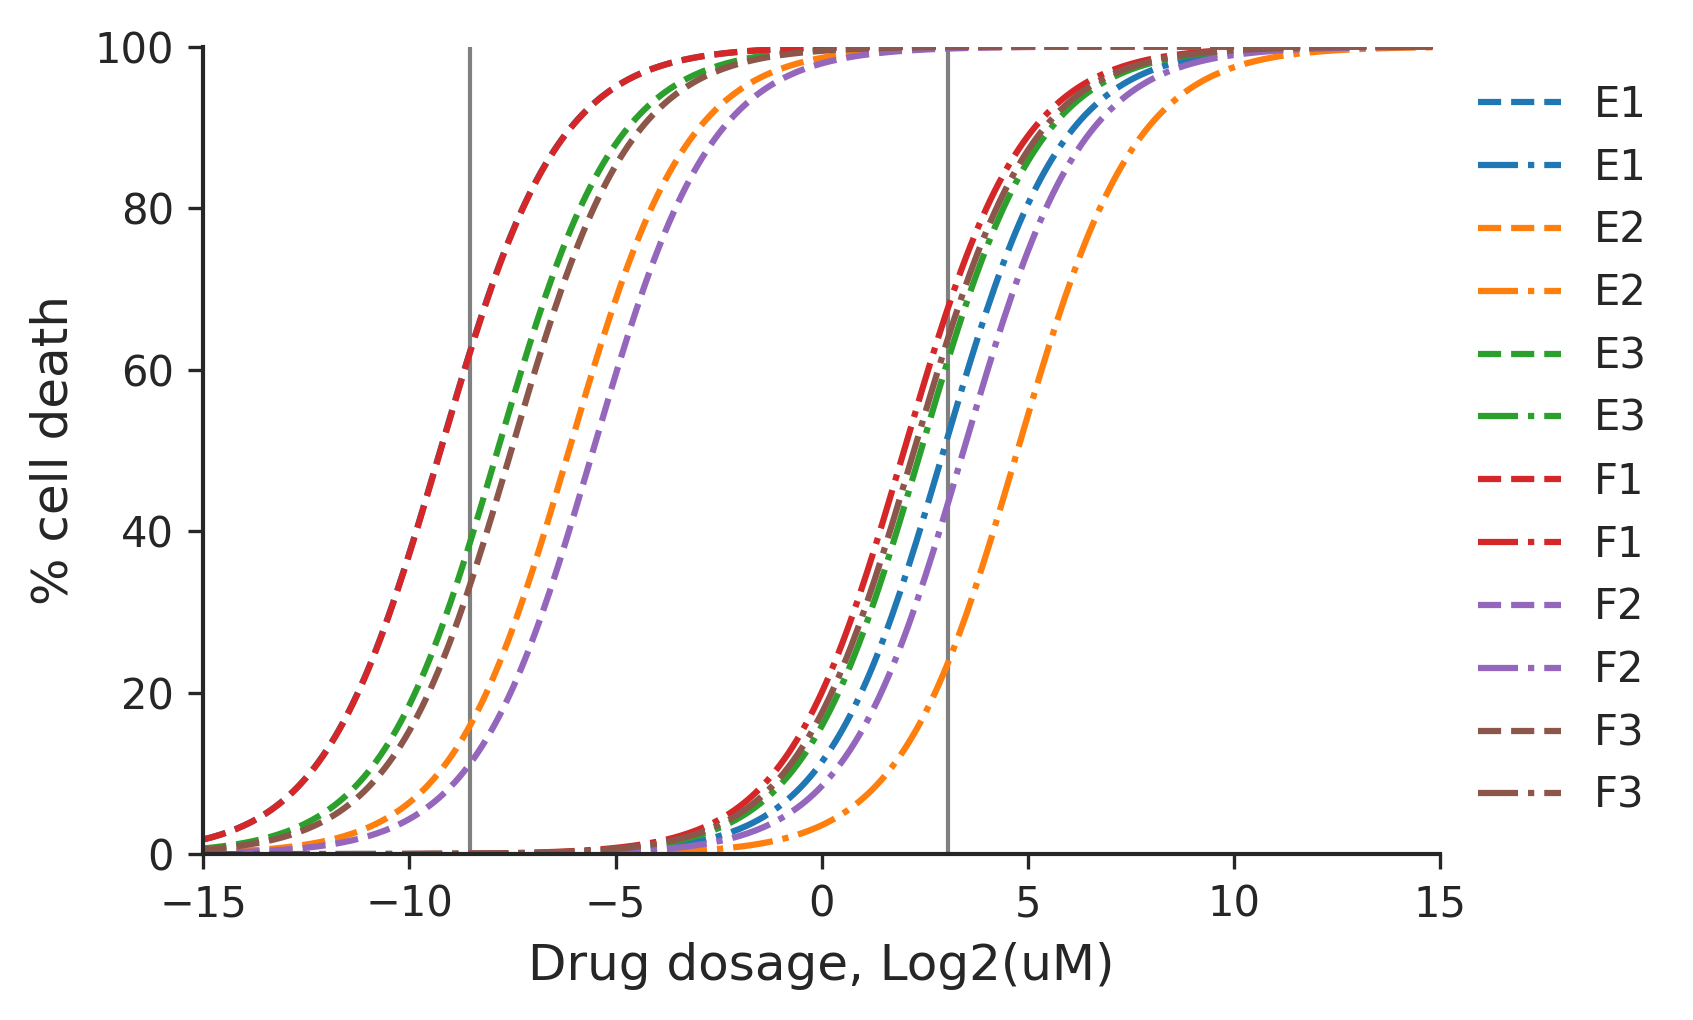

In [88]:
fig, ax = plt.subplots(figsize=(5, 3.5))

cmap = plt.cm.get_cmap('tab10', 12)
color_list = [cmap(i/12) for i in range(1, 12+1)]

x = np.arange(-15, 15, step=0.1)

count = 0
for cluster in cluster_list:
    
    pos = cadrres_cluster_df.loc[cluster, '201']
    y = 100 - (100 / (1 + (np.power(2, x-pos))))
    plt.plot(x, y, color=color_list[count], linestyle='--', label=cluster)
    
    pos = cadrres_cluster_df.loc[cluster, '302']
    y = 100 - (100 / (1 + (np.power(2, x-pos))))
    plt.plot(x, y, color=color_list[count], linestyle='-.', label=cluster)
    
    count += 1    

ax.set_xlim((-15, 15))
ax.set_ylim((0, 100))

ax.axvline(x=-8.52, linewidth=1, color='grey', zorder=0)
ax.axvline(x=3.06, linewidth=1, color='grey', zorder=0)

ax.set_xlabel('Drug dosage, Log2(uM)')
ax.set_ylabel('% cell death')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0, markerscale=2., fontsize=10)

sns.despine()
plt.tight_layout()

plt.savefig('../figure/supplementary_ic50_kill.svg')